# What do I usually eat?

An examination of using Monte Carlo methods to extract statistically significant results from difficult problems.

Z. W. Miller - 1/19/18

## Let's start by importing the stuff we'll need and then checking some version numbers. Note that we're in Python 3 here.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


# Getting started with a matrix

Let's setup a matrix that tells us, "if I ate this meal today, what are the chances I eat THAT meal tomorrow." We'll set it up like this: rows are "today's meal" and columns are "chances of this meal tomorrow, given today's meal"

|      | Beef | Chkn | Vege |
|------|------|------|------|
| Beef |  25% |  50% |  25% |
| Chkn |  75% |  20% |  5%  |
| Vege |  50% |  50% |  0%  |

Now looking at this, it's not easy to know what your "average meal distribution" will look like. We could try to figure out the coupled probabilities and then calculate it all out. Or, we could just write a quick Python loop. Let's talk about how the latter works. We can randomly choose which meal to start with, let's say it's beef. Then we look at the probabilities of each next meal, and roll a dice to decide which one we will have. If we track all the meals we're having, we can eventually figure out what portion of our meals are fall in each category.

Yes, this is a trivial example - but we're going to use it to see how the machinery of Monte Carlo works before we jump into more challenging problems. 

For this problem we'll encode beef as id 0, chicken as id 1, and vegetarian as id 2 (since that's the way the lists are indexed).

In [5]:
dinner_matrix  = [[.25, .5, .25],
                  [.75, .2, .05],
                  [.50, .5, 0.0]]

possible_options = [0, 1, 2]

starting_meal = np.random.choice(possible_options)
print(starting_meal)

2


We'll use a dictionary to keep track of which meal has been consumed. To do that, we'll just have each meal get a key (its id) and a value (the counter). We also need to talk about how we're going to use the dinner_matrix. Since it's a set of probabilities, we're going to use them to tell our dice roller how to behave. In numpy, there's an option called np.random.choice (seen above). It grabs one element out of a list of options and gives it back to you. By default, it chooses from all elements equally. However, if we tell give it a list of probabilities as its `p` kwarg, it will use those to make sure it samples the choices with the correct probabilities. So, if we eating a meal of beef, we just need to give the list of "I just ate beef" probabilities to the np.random.choice as weights or probabilities. That's been done below.

In [15]:
number_of_meals_to_simulate = 1000000
meal_counter = {0:0, 1:0, 2:0} 

meal = starting_meal
meal_counter[meal] += 1
for _ in range(number_of_meals_to_simulate):
    meal = np.random.choice(possible_options, p=dinner_matrix[meal])
    meal_counter[meal] += 1
    
print(meal_counter)

{0: 476518, 1: 384469, 2: 139014}


Let's convert these back to percentages so we can get a nice clear picture of what the result is.

In [19]:
meal_names = ['beef','chicken','vegetarian']
for key, value in meal_counter.items():
    print(meal_names[key], ": ", "%.3f"%(value/number_of_meals_to_simulate*100.))

beef :  47.652
chicken :  38.447
vegetarian :  13.901


Some neat results here! So first, even though the "going to be beef" had transition probabilities of 25%, 75%, and 50%... they don't quite balance out to be exactly 50%. This is because they don't happen equally - it's not just a pure average, because each state has a different likelihood of being the one we're "eating now." We see also that the same is true for chicken and vegetarian meals - the results follow along with the trend, but the exact value is quite non-obvious. 

Let's write a little method to track the "beef percentage as we run through all of our meals. That way we can see how it fluctuates as we run more-and-more simulations.

In [37]:
number_of_meals_to_simulate = 100000
meal_counter = {0:0, 1:0, 2:0} 
beef_percentage_over_time = []

meal = starting_meal
meal_counter[meal] += 1
for simulation_number in range(number_of_meals_to_simulate):
    meal = np.random.choice(possible_options, p=dinner_matrix[meal])
    meal_counter[meal] += 1
    beef_percentage_over_time.append(meal_counter[0]/(simulation_number+1)) # +1 so we don't divide by 0

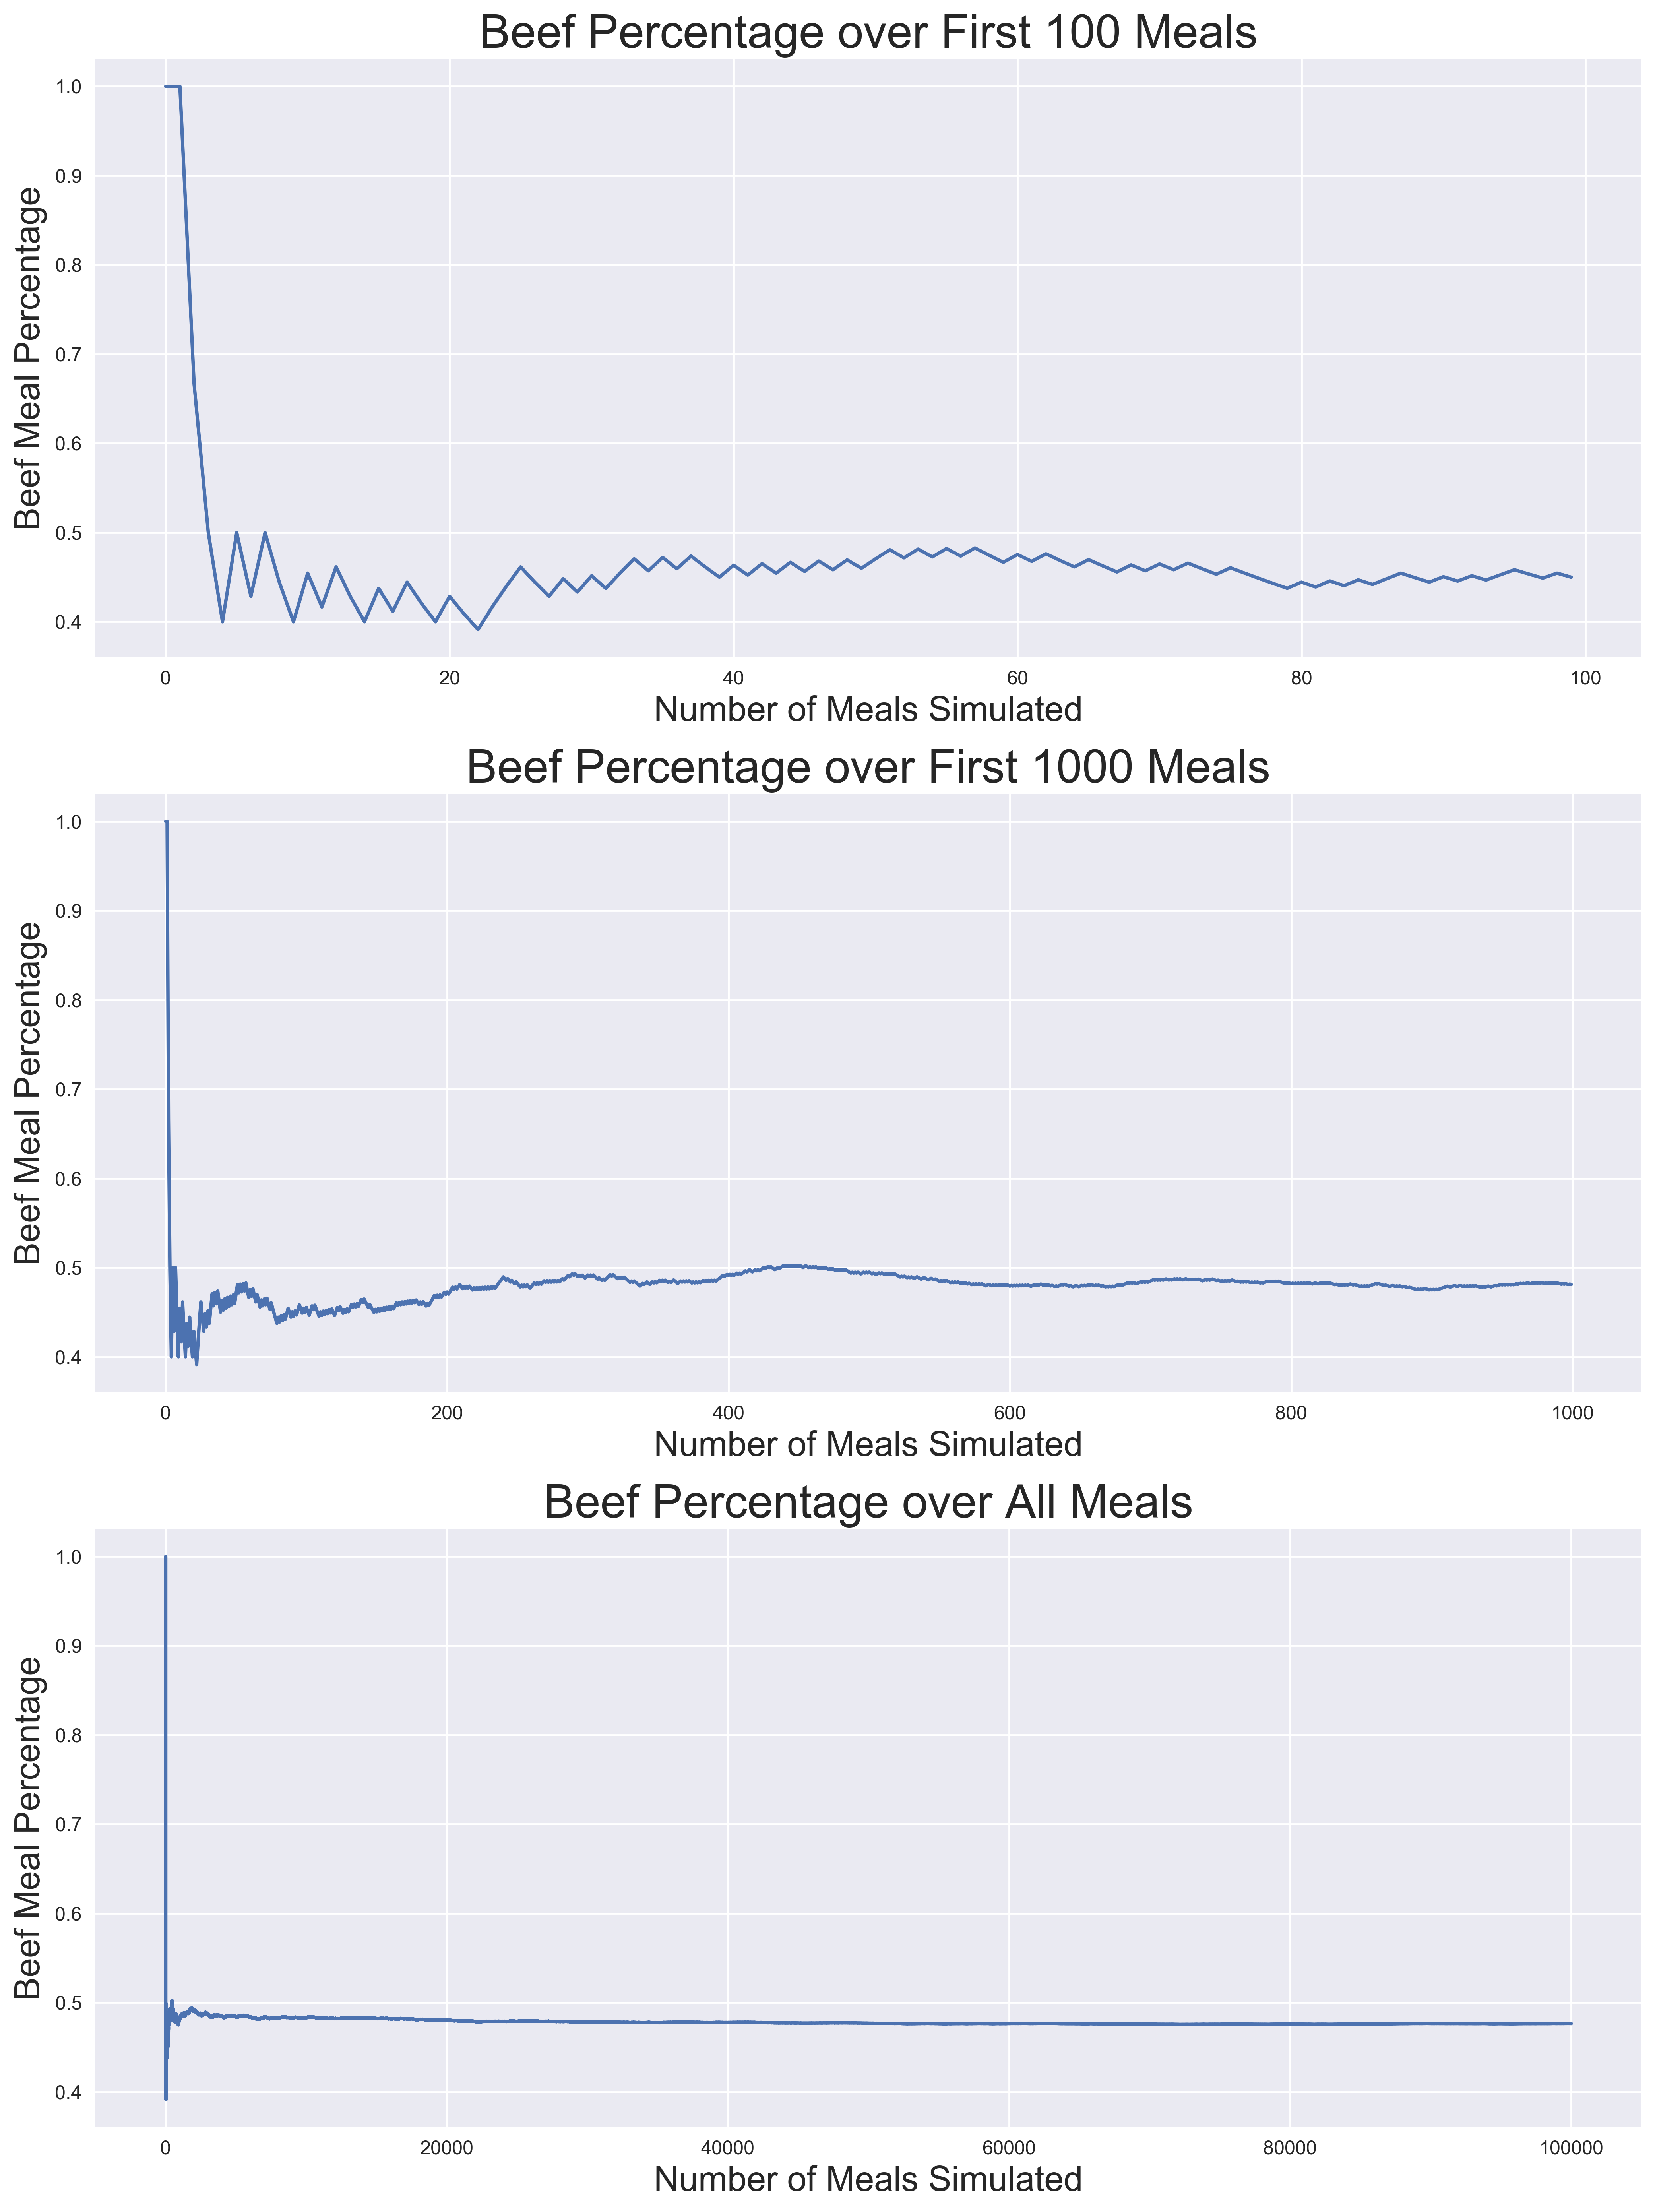

In [38]:
fig, ax = plt.subplots(3,1, dpi=350, figsize=(12,16))
ax[0].plot(range(number_of_meals_to_simulate)[:100], beef_percentage_over_time[:100])
ax[1].plot(range(number_of_meals_to_simulate)[:1000], beef_percentage_over_time[:1000])
ax[2].plot(range(number_of_meals_to_simulate), beef_percentage_over_time);
ax[0].set_title("Beef Percentage over First 100 Meals", fontsize=24);
ax[1].set_title("Beef Percentage over First 1000 Meals", fontsize=24);
ax[2].set_title("Beef Percentage over All Meals", fontsize=24);
ax[0].set_xlabel("Number of Meals Simulated", fontsize=18)
ax[1].set_xlabel("Number of Meals Simulated", fontsize=18)
ax[2].set_xlabel("Number of Meals Simulated", fontsize=18)
ax[0].set_ylabel("Beef Meal Percentage", fontsize=18)
ax[1].set_ylabel("Beef Meal Percentage", fontsize=18)
ax[2].set_ylabel("Beef Meal Percentage", fontsize=18)
plt.tight_layout()

Well, that's neat. We can see that over the first 100 meals, there was quite a bit of noise in the simulation. Lots of still figuring things out because of the randomness. Even over 1000 meals, there still some "wavy-ness" as it's trying to settle down into a steady state that describes the true probabilistic understanding. However, by the time we get out to 100,000 meals, you can see that the line is flattened out quite nicely! That means that the result we're getting (of 47.6%) is truly representative of our actual probability. We've used randomness, to extract a probabilistic understanding of our meal times!

# Back to http://zwmiller.com/projects/monte_carlo_part2.html